In [1]:
# Предварительные настройки Colab для работы с Google Drive

from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
# Предварительные настройки Colab для работы с Kaggle


from google.colab import files

files.upload()

!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle

# !kaggle datasets download -d jutrera/stanford-car-dataset-by-classes-folder
# !unzip /content/stanford-car-dataset-by-classes-folder.zip

In [2]:
import os
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import random
import seaborn as sns
import torch.nn as nn
import torch, torchvision
import matplotlib.pyplot as plt

from tqdm import tqdm, trange
from torchvision import transforms, models
from sklearn.preprocessing import LabelEncoder
from torch.utils.data import DataLoader
from sklearn.metrics import accuracy_score

In [33]:
TRAIN_PATH = "/content/drive/MyDrive/train/"
TEST_PATH = "/content/drive/MyDrive/test/"

In [18]:
RESCALE_SIZE = 300
DEVICE = torch.device("cuda") # We will use GPU
NCATS = len(os.listdir(TRAIN_PATH))

In [19]:
def seed_worker(worker_id):
    np.random.seed(42)
    random.seed(42)

In [43]:
# с AutoAugmentPolicy CIFAR10 показатели упали. Другие пока не пробовала. Available policies are IMAGENET, CIFAR10 and SVHN.

train_transforms = transforms.Compose([transforms.Resize((RESCALE_SIZE, RESCALE_SIZE)),
                                 transforms.RandomHorizontalFlip(),
                                 transforms.AutoAugment(transforms.AutoAugmentPolicy.CIFAR10),
                                 transforms.ToTensor(),
                                 transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))])


test_transforms = transforms.Compose([transforms.Resize((RESCALE_SIZE, RESCALE_SIZE)),
                                transforms.ToTensor(),
                                transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))])


train_dataset = torchvision.datasets.ImageFolder(root=TRAIN_PATH, transform = train_transforms)
test_dataset = torchvision.datasets.ImageFolder(root=TEST_PATH, transform = test_transforms)

In [ ]:
# без AutoAugmentPolicy показатели выше
train_transforms = transforms.Compose([transforms.Resize((RESCALE_SIZE, RESCALE_SIZE)),
                                 transforms.RandomHorizontalFlip(),
                                 transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))])


test_transforms = transforms.Compose([transforms.Resize((RESCALE_SIZE, RESCALE_SIZE)),
                                transforms.ToTensor(),
                                transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))])


train_dataset = torchvision.datasets.ImageFolder(root=TRAIN_PATH, transform = train_transforms)
test_dataset = torchvision.datasets.ImageFolder(root=TEST_PATH, transform = test_transforms)

In [44]:
trainloader = DataLoader(train_dataset, batch_size = 32, shuffle=True, num_workers = 2, worker_init_fn=seed_worker)
testloader = DataLoader(test_dataset, batch_size = 32, shuffle=False, num_workers = 2, worker_init_fn=seed_worker)

In [45]:
#Вспомогательные функции для отображения картинок и графиков

import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt


def imshow(inp, title=None, plt_ax=plt, default=False):
    """Imshow for tensors"""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt_ax.imshow(inp)
    if title is not None:
        plt_ax.set_title(title)
    plt_ax.grid(False)

def plot_loss(losses):
  """Train / val loss visualization"""
  sns.set(style="whitegrid", font_scale=1.4)
  plt.figure(figsize=(12, 8))
  plt.plot(losses['train'], label="train")
  plt.plot(losses['val'], label="val")
  plt.legend()
  plt.show()

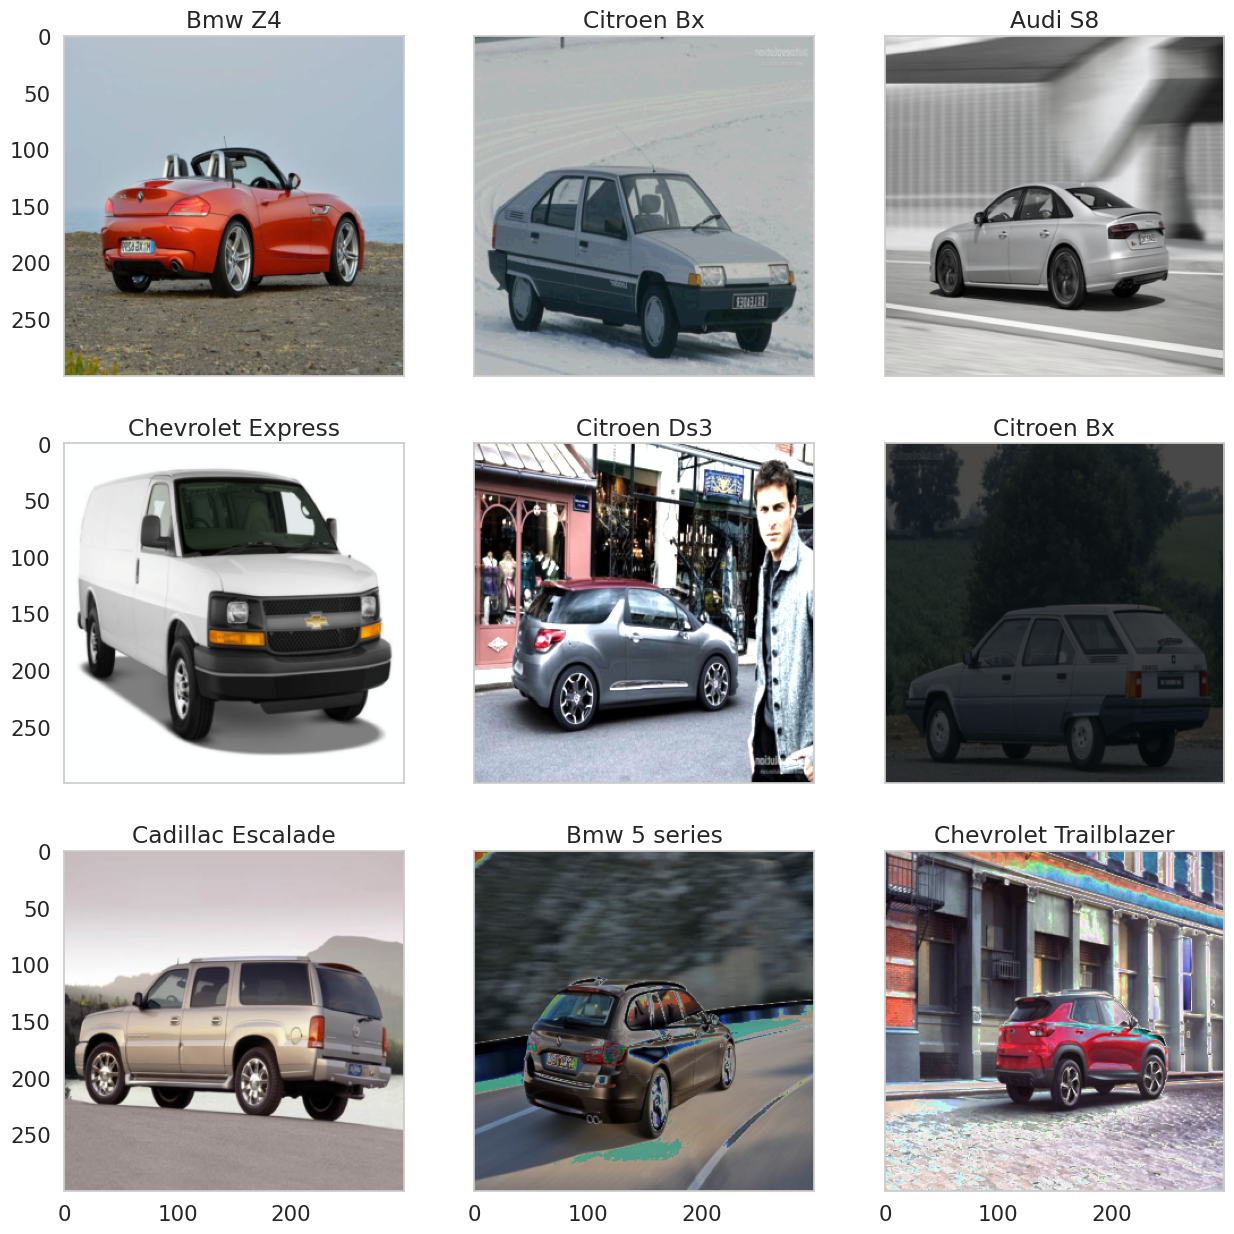

In [46]:
# Проверяем, что изображения загрузились и отображаются корректно

fig, ax = plt.subplots(nrows=3, ncols=3,figsize=(15, 15), \
                        sharey=True, sharex=True)

train_size = len(train_dataset)

label_encoder = LabelEncoder().fit(train_dataset.classes)

for fig_x in ax.flatten():
    random_characters = int(np.random.uniform(0, train_size))
    im_train, label = train_dataset[random_characters]
    img_label = " ".join(map(lambda x: x.capitalize(), str(label_encoder.inverse_transform([label])[0]).split('_')))
    plt.imshow(im_train.permute(1, 2, 0)  )
    imshow(im_train.data.cpu(), plt_ax=fig_x, title=img_label)

In [47]:
def train(train_loader, val_loader, model, num_epochs, optimizer, criterion, scheduler=None):

    best_model_wts = model.state_dict()
    best_epoch = 0
    best_score = 0


    losses = {'train': [], "val": []}

    pbar = trange(num_epochs, desc="Epoch:")

    loaders = {"train": train_loader, "val": val_loader}

    for epoch in pbar:

        for k, dataloader in loaders.items():

            running_loss = 0.0
            epoch_preds, epoch_batches = [], []

            for batch in tqdm(dataloader, leave=False, desc=f"{k} iter:"):
                x_batch, y_batch = batch
                x_batch = x_batch.to(DEVICE)
                y_batch = y_batch.to(DEVICE)
                if k == "train":
                    model.train()
                    optimizer.zero_grad()
                    outp = model(x_batch)
                    loss = criterion(outp, y_batch)
                    loss.backward()
                    optimizer.step()
                else:
                    model.eval()
                    with torch.no_grad():
                        outp = model(x_batch)
                        loss = criterion(outp, y_batch)

                preds = outp.argmax(-1)

                epoch_preds += preds.cpu()
                epoch_batches += y_batch.cpu()
                running_loss += loss.item() * x_batch.size(0)

            epoch_score = accuracy_score(epoch_preds, epoch_batches)
            epoch_loss = running_loss / len(dataloader.dataset)
            losses[k].append(epoch_loss)



            if k == 'val':
              print(f'Epoch: {epoch + 1} of {num_epochs}  Score: {epoch_score}')
              if scheduler is not None:
                scheduler.step(epoch_loss)

            pbar.set_description('{} Loss: {:.4f} Score: {:.4f}'.format(k, epoch_loss, epoch_score))

            if k == 'val' and epoch_score > best_score:
               best_score = epoch_score
               best_epoch = epoch + 1
               best_model_wts = model.state_dict()



    print(f'Best score: {best_score}\nEpoch {best_epoch} of {num_epochs}')
    model.load_state_dict(best_model_wts)
    return model, losses, best_score

In [ ]:
torch.cuda.empty_cache()

In [49]:
mob_netv2 = models.mobilenet_v2(pretrained=True)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [50]:
mob_netv2.classifier[1] = nn.Linear(in_features=mob_netv2.classifier[1].in_features, out_features=NCATS)

In [51]:
mob_netv2 = mob_netv2.to(DEVICE)

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(mob_netv2.parameters(), lr=1e-4, weight_decay = 1e-5)

mob_netv2, losses_mob_netv2, accuracy_mob_netv2 = train(trainloader, testloader, model=mob_netv2, num_epochs=10, optimizer=optimizer, criterion=criterion)

In [30]:
torch.save(mob_netv2.state_dict(), '/content/mob_netv2_no_submodel.pth')

In [ ]:
from torchsummary import summary

model = mob_netv2
summary(model, (3, 224, 224))

In [ ]:
plot_loss(losses_mob_netv2)